From https://ccrma.stanford.edu/~jatin/ComplexNonlinearities/Wavefolder.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import audio_dspy as adsp

In [2]:
def tri_wave(x, freq, fs):
    p = float((1 / freq) * fs)
    x = x + p / 4
    return 4 * np.abs((x / p) - np.floor((x / p) + 0.5)) - 1

def sine_wave(x, freq, fs):
    return np.sin(2 * np.pi * x * freq / fs)

Text(0.5, 1.0, 'Sine Wavefolder Static Curve')

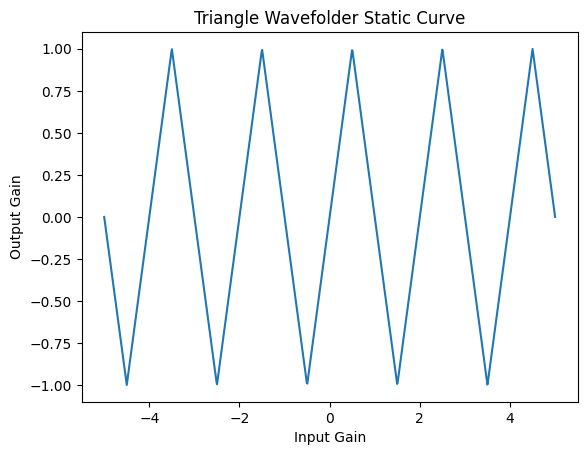

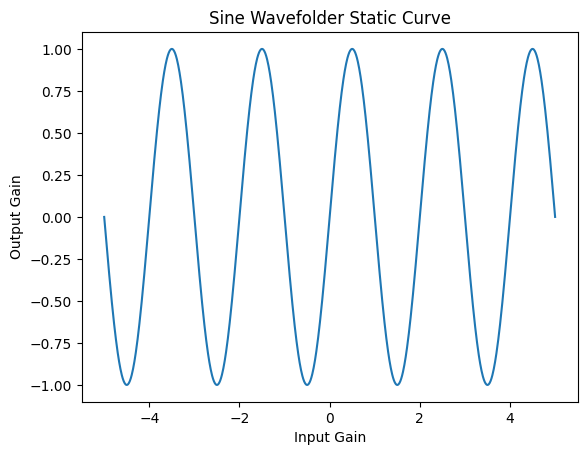

In [3]:
fs = 44100

plt.figure()
adsp.plot_static_curve(lambda x : tri_wave(x, fs/2, fs), gain = 5)
plt.title('Triangle Wavefolder Static Curve')

plt.figure()
adsp.plot_static_curve(lambda x : sine_wave(x, fs/2, fs), gain = 5)
plt.title('Sine Wavefolder Static Curve')

# Standard Digital Wavefolding

The typical method for implementing a digital wavefolding effect is to modulate the input signal by another wave, often a triangle or sine wave. This means that the static curves we're used to looking at for nonlinear effects will be simple triangle or sine waves.

Text(0.5, 1.0, 'Folded Sine Wave')

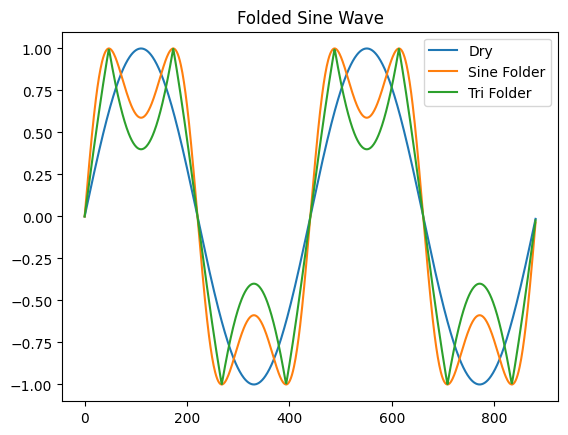

In [4]:
N = fs / 50
n = np.arange(N)
freq = 100
x = np.sin(2 * np.pi * n * freq / fs)
y = sine_wave(x,  fs/2.5, fs)
y2 = tri_wave(x, fs/2.5, fs)

plt.plot(x)
plt.plot(y)
plt.plot(y2)
plt.legend(['Dry', 'Sine Folder', 'Tri Folder'])
plt.title('Folded Sine Wave')

# Modified Wavefolding 1: Saturation

The first modification we'll make to the traditional digital wavefolder is to sum the outputs of a saturating nonlinearity and a wavefolding nonlinearity. Although I haven't compared the two on a mathematical level, I've found through my own listening tests that this architecture sounds a little bit more similar to a typical analog wavefolder, especially for large amounts of folding.

In [5]:
def sine_tanh(x, G, freq, fs):
    return np.tanh(x) + G * sine_wave(x, freq, fs)

Text(0.5, 1.0, 'Wavefolder vs. Saturating Wavefolder')

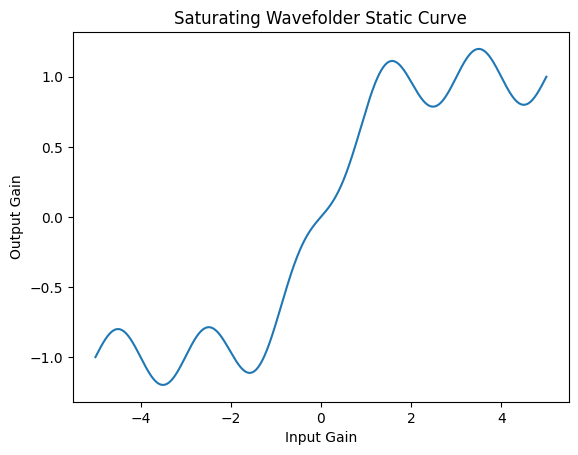

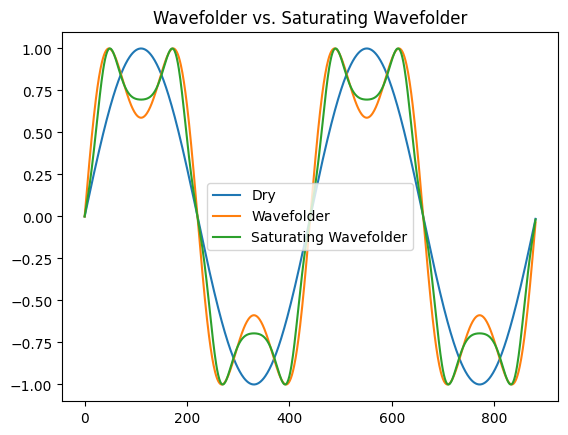

In [6]:
plt.figure()
adsp.plot_static_curve(lambda x : sine_tanh(x, -0.2, fs/2, fs), gain=5)
plt.title('Saturating Wavefolder Static Curve')

y3 = adsp.normalize(sine_tanh(3*x, -0.2, fs/2.5, fs))

plt.figure()
plt.plot(x)
plt.plot(y)
plt.plot(y3)
plt.legend(['Dry', 'Wavefolder', 'Saturating Wavefolder'])
plt.title('Wavefolder vs. Saturating Wavefolder')

Text(0.5, 1.0, 'Wavefolder vs. Saturating Wavefolder For Large Input')

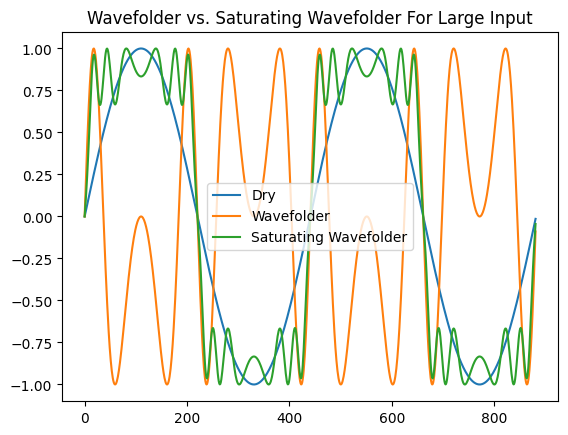

In [7]:
N = fs / 50
n = np.arange(N)
x = 2.5 * np.sin(2 * np.pi * n * freq / fs)
y = sine_wave(x, fs/2.5, fs)
y3 = adsp.normalize(sine_tanh(3*x, -0.2, fs/2.5, fs))

plt.figure()
plt.plot(adsp.normalize(x))
plt.plot(y)
plt.plot(y3)
plt.legend(['Dry', 'Wavefolder', 'Saturating Wavefolder'])
plt.title('Wavefolder vs. Saturating Wavefolder For Large Input')

# Modified Wavefolder 2: Feedback


In [8]:
class WaveFolder:
    def __init__(self):
        self.y1 = 0
        self.fb = lambda _ : 0
        self.ff = lambda x : x
        self.wave = lambda x : x

    def process(self, x):
        z = self.ff(x) + self.fb(self.y1)
        y = z + self.wave(x)

        self.y1 = y
        return y

    def process_block(self, block):
        out = np.copy(block)

        for n, _ in enumerate(block):
            out[n] = self.process(block[n])

        return out

Text(0.5, 1.0, 'Saturating Feedback Wavefolder Dynamic Response')

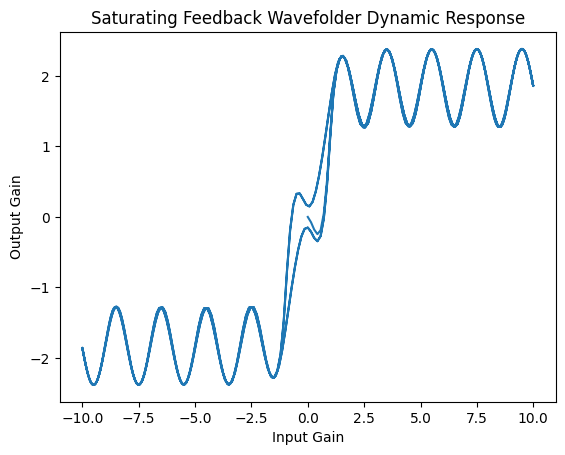

In [9]:
WF = WaveFolder()
WF.ff = lambda x : np.tanh(x)
WF.fb = lambda x : 0.9*np.tanh(x)
WF.wave = lambda x : -0.5*sine_wave(x, fs/2, fs)

adsp.plot_dynamic_curve(lambda x : WF.process_block(x))
plt.title('Saturating Feedback Wavefolder Dynamic Response')

# Antialiasing

Wavefolders are notorious for having a pretty gnarly harmonic response, which can result in some serious aliasing distortion if not handled properly. First, let's look at the harmonic response for the traditional digital wavefolder, for both sine and triangle waves.

plot_harmonic_response throws a type error:

    plt.figure()
    adsp.plot_harmonic_response(lambda x : tri_wave(x, fs/2, fs), gain=2)
    plt.title('Triangle Wavefolder Harmonic Response')

    plt.figure()
    adsp.plot_harmonic_response(lambda x : sine_wave(x, fs/2, fs), gain=2)
    plt.title('Sine Wavefolder Harmonic Response')